## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, cross_val_score, RepeatedKFold
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/owid-covid-data.csv")
df.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [3]:
df = df.loc[df["location"] == "Spain", ["date", "new_cases", "new_deaths", "population", "total_cases", "total_deaths"]]

In [4]:
df.isna().sum()

date             0
new_cases        0
new_deaths      31
population       0
total_cases      0
total_deaths    31
dtype: int64

In [5]:
df = df.dropna()
df = df.set_index("date")
df.head()

,new_cases,new_deaths,population,total_cases,total_deaths
date,,,,,
2020-03-03,45.0,1.0,46754783.0,165.0,1.0
2020-03-04,57.0,1.0,46754783.0,222.0,2.0
2020-03-05,37.0,1.0,46754783.0,259.0,3.0
2020-03-06,141.0,2.0,46754783.0,400.0,5.0
2020-03-07,100.0,5.0,46754783.0,500.0,10.0


### 1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

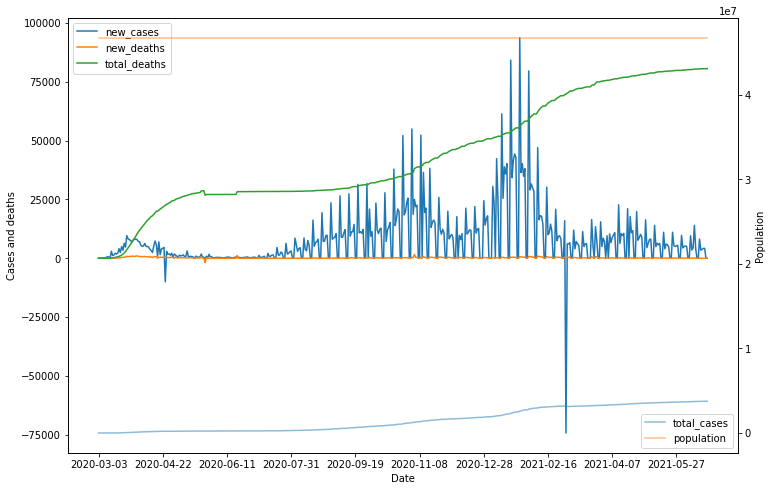

In [6]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(df.index, df[['new_cases', 'new_deaths', "total_deaths"]], label = ['new_cases', 'new_deaths', "total_deaths"])

ax.set_xlabel("Date")
ax.set_ylabel("Cases and deaths")
ax.legend(['new_cases', 'new_deaths', 'total_deaths'])

ax2 = ax.twinx()
ax2.plot(df.index, df[['total_cases', "population"]], label = ['total_cases', "population"], alpha = .5)
ax2.set_ylabel("Population")
ax2.set_xticks(df.index[::50])
ax2.legend(["Total cases", "Population"])

plt.legend()
plt.show()

### 2. Elimina la columna "Población".

In [7]:
df = df.drop("population", axis = 1)
df.head()

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-03-03,45.0,1.0,165.0,1.0
2020-03-04,57.0,1.0,222.0,2.0
2020-03-05,37.0,1.0,259.0,3.0
2020-03-06,141.0,2.0,400.0,5.0
2020-03-07,100.0,5.0,500.0,10.0


### 3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

In [8]:
# Independent variables
X = df[["total_cases", "total_deaths"]]

# Dependent variables
y1 = df["new_cases"]
y2 = df["new_deaths"]

ys = [y1, y2]

# Models
lin = LinearRegression(n_jobs = -1)
svr = SVR(kernel = "rbf", C = 100, gamma = 0.1, epsilon = 0.1)
rf = RandomForestRegressor(n_estimators = 200, random_state = 42)

models = [lin, svr, rf]
model_names = ["lin", "svr", "rf"]

# To save the data
scores = {}
rmses = {}


for ind1, model_ in enumerate(models):
    y_scores = {}
    y_rmses = {}

    count = 1

    for y in ys:
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

        # Model
        #lin_model = LinearRegression(n_jobs = -1)

        # Cross validation
        kfold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

        # To store y_i data
        train_scores = []
        val_scores = []

        train_rmses = []
        val_rmses = []

        for ind2, (train, val) in enumerate(kfold.split(X_train)):
            # Training
            model_.fit(X_train.values[train], y_train.values[train])

            y_train_pred = model_.predict(X_train.values[train])
            y_val_pred = model_.predict(X_train.values[val])

            # Scores
            train_score = model_.score(X_train.values[train], y_train.values[train])
            val_score = model_.score(X_train.values[val], y_train.values[val])

            # RMSE
            train_rmse = np.sqrt(mean_squared_error(y_train.values[train], y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_train.values[val], y_val_pred))

            # Saving the scores and rmses
            train_scores.append(train_score)
            val_scores.append(val_score)

            train_rmses.append(train_rmse)
            val_rmses.append(val_rmse)

        y_scores["y" + str(count)] = {"train_scores" : train_scores, "val_scores" : val_scores}
        y_rmses["y" + str(count)] = {"train_rmses" : train_rmses, "val_rmses" : val_rmses}

        count += 1
    
    scores[model_names[ind1]] = y_scores
    rmses[model_names[ind1]] = y_rmses

# Example
scores

{'lin': {'y1': {'train_scores': [0.05278244205335292,
    0.051756279376521164,
    0.06269436436472275,
    0.05061877717244179,
    0.050501829826246625,
    0.07315269679095748,
    0.055731214498750625,
    0.056020517892876875,
    0.053455622668358904,
    0.062016685164222984],
   'val_scores': [0.09482312375245627,
    0.10707979402598633,
    -0.0009623309483492992,
    0.12410219384932142,
    0.1504074330044528,
    -0.054753685732078505,
    0.02654549332216416,
    -0.01545746351653876,
    0.048768788234475946,
    -0.006199960088578926]},
  'y2': {'train_scores': [0.14138098460198945,
    0.14615793245134734,
    0.14975728099636176,
    0.12578242524405947,
    0.13888663836546766,
    0.12017291453630674,
    0.13345630296991207,
    0.14402104426389495,
    0.14040711012903773,
    0.14730366648366333],
   'val_scores': [0.049527625932098696,
    0.09593191538975698,
    -0.13314264522764607,
    0.25540150058931443,
    0.11228502777053928,
    0.37065387567564645,
 

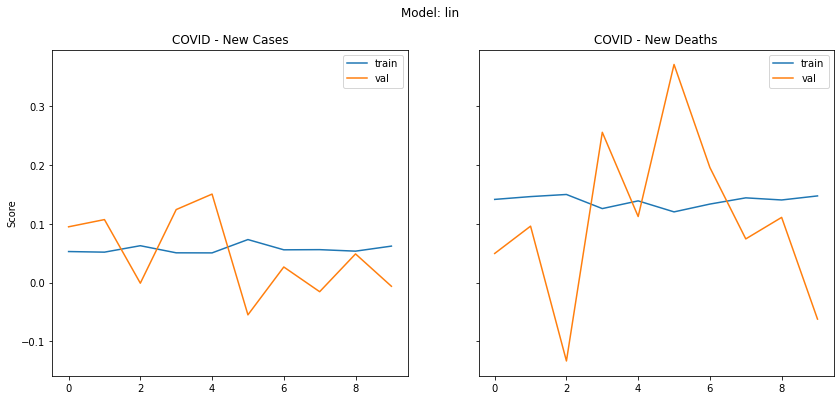

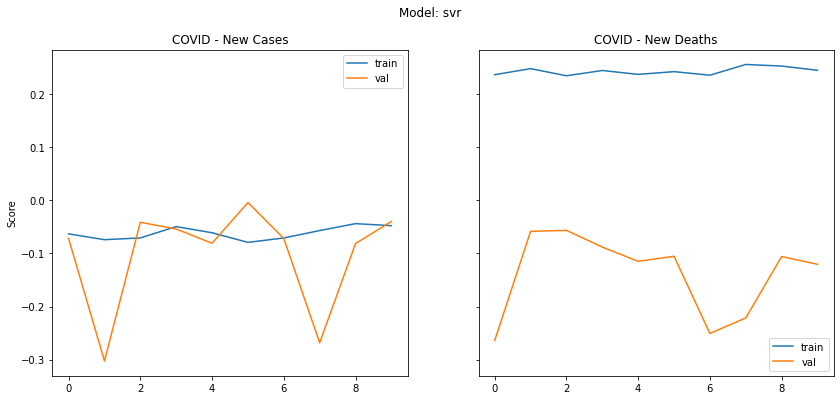

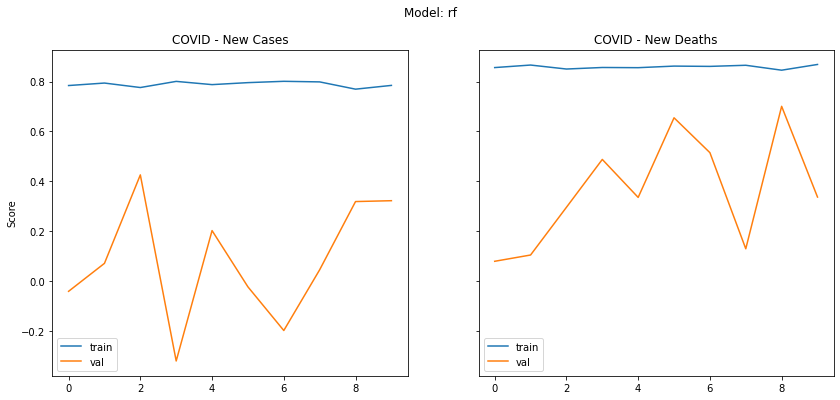

In [9]:
for model_ in model_names:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # For y1
    ax1.plot(scores[model_]["y1"]["train_scores"])
    ax1.plot(scores[model_]["y1"]["val_scores"])
    ax1.set_ylabel("Score")
    ax1.legend(["train", "val"])
    ax1.set_title("COVID - New Cases")

    # For y2
    ax2.plot(scores[model_]["y2"]["train_scores"])
    ax2.plot(scores[model_]["y2"]["val_scores"])
    ax2.legend(["train", "val"])
    ax2.set_title("COVID - New Deaths")

    plt.suptitle(f"Model: {model_}")
    plt.show()

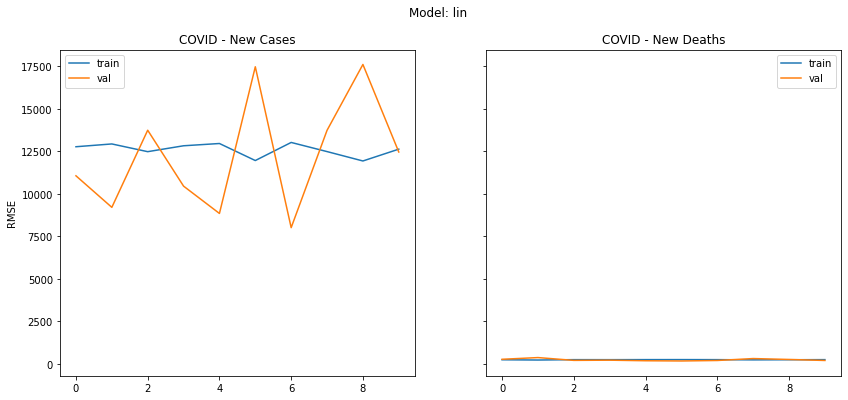

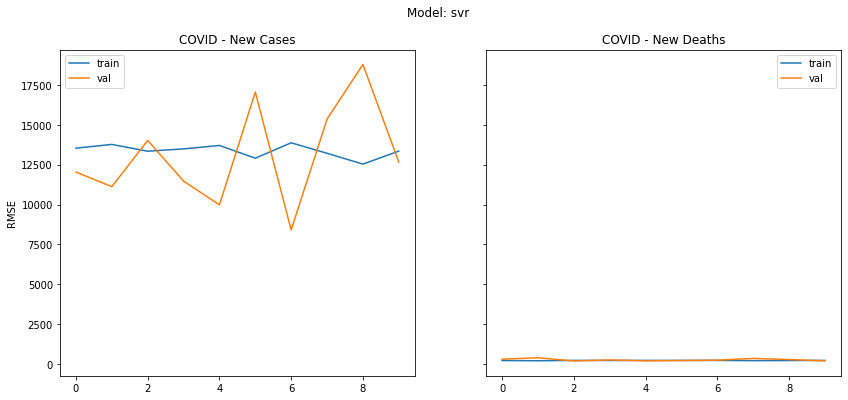

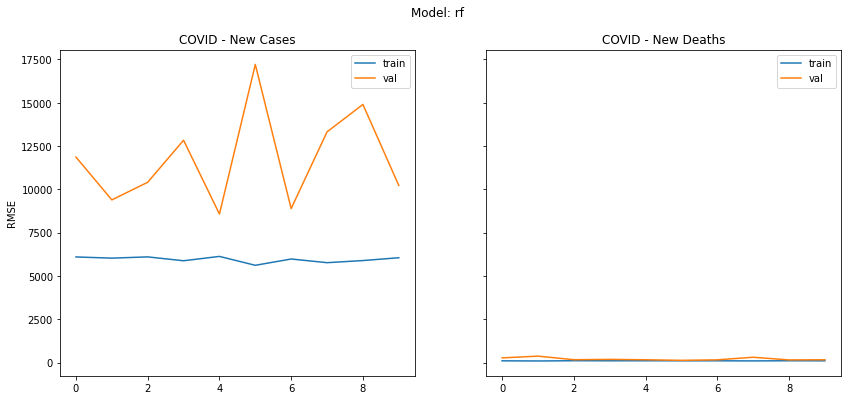

In [10]:
for model_ in model_names:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # For y1
    ax1.plot(rmses[model_]["y1"]["train_rmses"])
    ax1.plot(rmses[model_]["y1"]["val_rmses"])
    ax1.set_ylabel("RMSE")
    ax1.legend(["train", "val"])
    ax1.set_title("COVID - New Cases")

    # For y2
    ax2.plot(rmses[model_]["y2"]["train_rmses"])
    ax2.plot(rmses[model_]["y2"]["val_rmses"])
    ax2.legend(["train", "val"])
    ax2.set_title("COVID - New Deaths")

    plt.suptitle(f"Model: {model_}")
    plt.show()

No parecen buenos modelos viendo los scores y los rmses. El modelo no está teniendo en cuenta que 1) los datos tienen una ordenación (fecha) y 2) la obversación anterior afecta a la siguiente.

### 4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [11]:
# Independent variables
X = df[["total_cases", "total_deaths"]]

# Dependent variables
y1 = df["new_cases"]
y2 = df["new_deaths"]

ys = [y1, y2]

# Models
lin = LinearRegression(n_jobs = -1)
svr = SVR(kernel = "rbf", C = 100, gamma = 0.1, epsilon = 0.1)
rf = RandomForestRegressor(n_estimators = 200, random_state = 42)

models = [lin, svr, rf]
model_names = ["lin", "svr", "rf"]

# To save the data
scores = {}
rmses = {}


for ind1, model_ in enumerate(models):
    y_scores = {}
    y_rmses = {}

    count = 1

    for y in ys:
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

        # Model
        #lin_model = LinearRegression(n_jobs = -1)

        # Cross validation
        kfold = RepeatedKFold(n_splits = 23, n_repeats = 7, random_state = 42)

        # To store y_i data
        train_scores = []
        val_scores = []

        train_rmses = []
        val_rmses = []

        for ind2, (train, val) in enumerate(kfold.split(X_train)):
            # Training
            model_.fit(X_train.values[train], y_train.values[train])

            y_train_pred = model_.predict(X_train.values[train])
            y_val_pred = model_.predict(X_train.values[val])

            # Scores
            train_score = model_.score(X_train.values[train], y_train.values[train])
            val_score = model_.score(X_train.values[val], y_train.values[val])

            # RMSE
            train_rmse = np.sqrt(mean_squared_error(y_train.values[train], y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_train.values[val], y_val_pred))

            # Saving the scores and rmses
            train_scores.append(train_score)
            val_scores.append(val_score)

            train_rmses.append(train_rmse)
            val_rmses.append(val_rmse)

        y_scores["y" + str(count)] = {"train_scores" : train_scores, "val_scores" : val_scores}
        y_rmses["y" + str(count)] = {"train_rmses" : train_rmses, "val_rmses" : val_rmses}

        count += 1
    
    scores[model_names[ind1]] = y_scores
    rmses[model_names[ind1]] = y_rmses

# Example
#scores

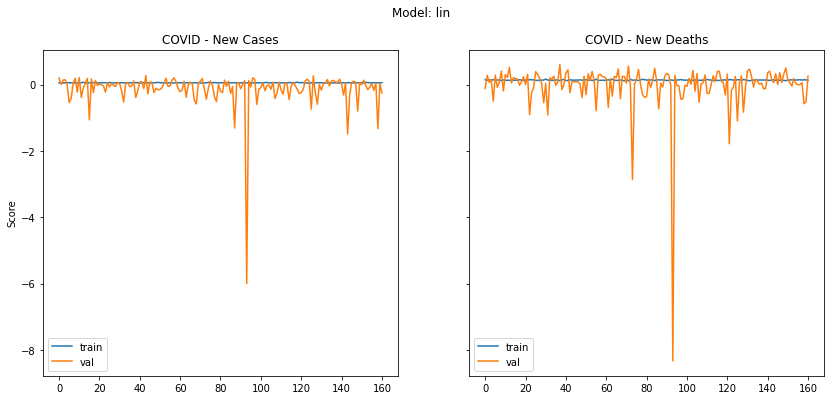

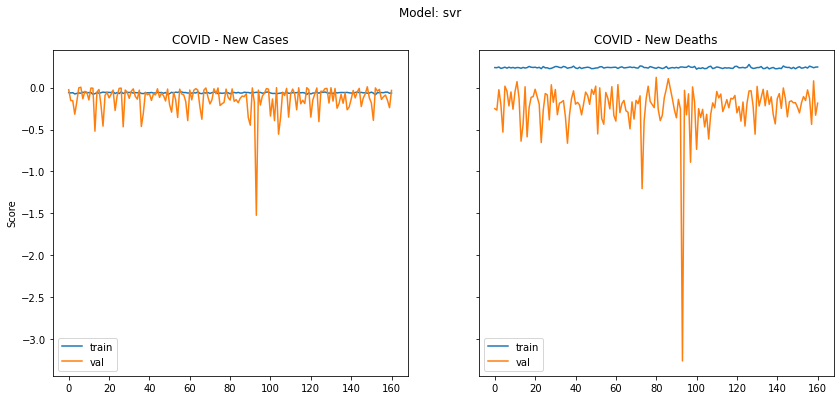

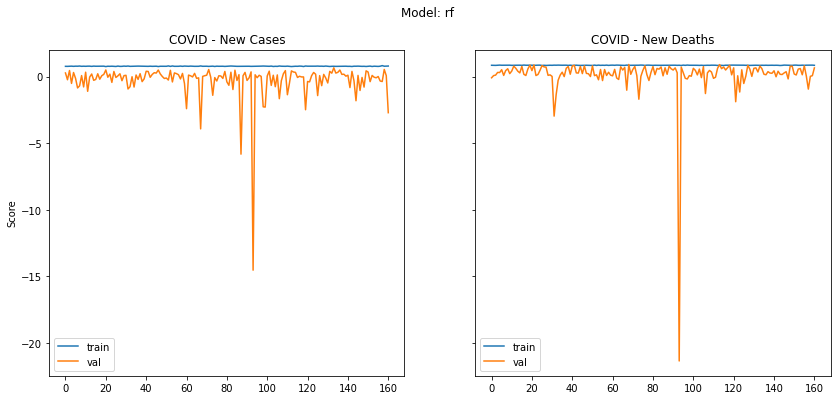

In [12]:
for model_ in model_names:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # For y1
    ax1.plot(scores[model_]["y1"]["train_scores"])
    ax1.plot(scores[model_]["y1"]["val_scores"])
    ax1.set_ylabel("Score")
    ax1.legend(["train", "val"])
    ax1.set_title("COVID - New Cases")

    # For y2
    ax2.plot(scores[model_]["y2"]["train_scores"])
    ax2.plot(scores[model_]["y2"]["val_scores"])
    ax2.legend(["train", "val"])
    ax2.set_title("COVID - New Deaths")

    plt.suptitle(f"Model: {model_}")
    plt.show()

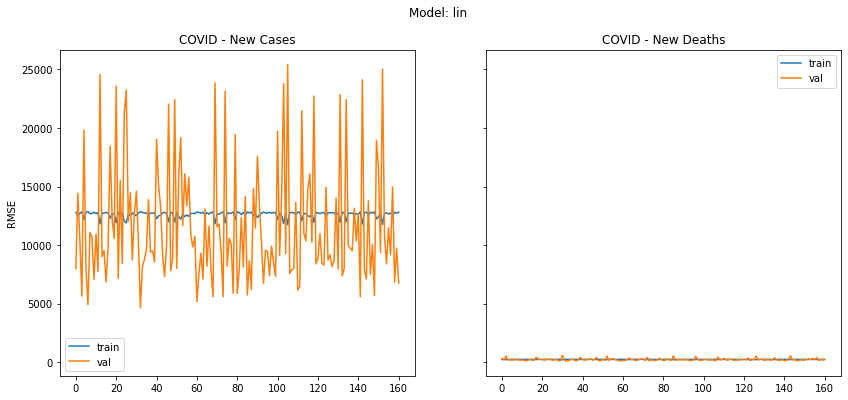

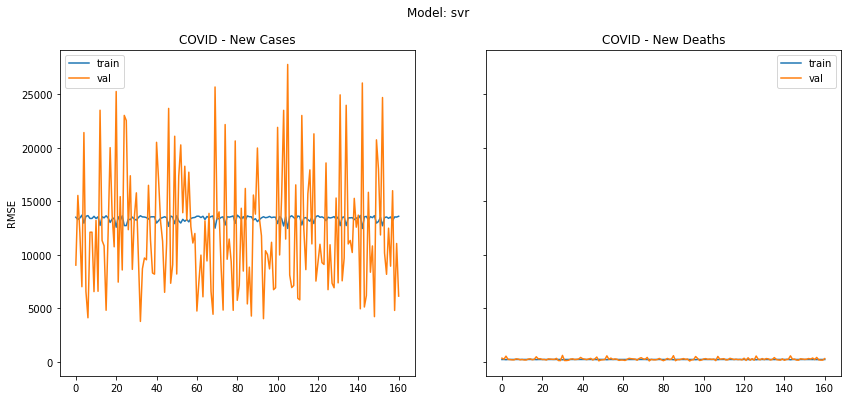

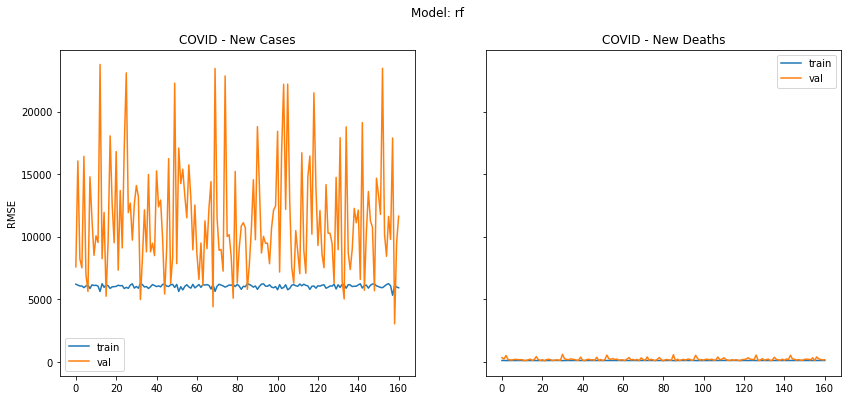

In [14]:
for model_ in model_names:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # For y1
    ax1.plot(rmses[model_]["y1"]["train_rmses"])
    ax1.plot(rmses[model_]["y1"]["val_rmses"])
    ax1.set_ylabel("RMSE")
    ax1.legend(["train", "val"])
    ax1.set_title("COVID - New Cases")

    # For y2
    ax2.plot(rmses[model_]["y2"]["train_rmses"])
    ax2.plot(rmses[model_]["y2"]["val_rmses"])
    ax2.legend(["train", "val"])
    ax2.set_title("COVID - New Deaths")

    plt.suptitle(f"Model: {model_}")
    plt.show()

Más que sobreaprendizaje, lo que parece es que el modelo no es capaz de identificar las tendencias.